You will probably get error after running the following cell because this opencv package is compatible with older versions of Python.However, opencv-contrib-python==3.4.2.16 is required for calling cv2.xfeatures2d.SIFT_create(), therefore unfortunately this notebook cannot function fully.There are rumours that Sift and Surf will be supported in the future opencv version, if there is a fix, I will update this notebook asap.

In [ ]:
pip install opencv-contrib-python==3.4.2.16

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
def normalize(matrix, new_min, new_max):
    min_ = np.min(matrix)
    max_ = np.max(matrix)
    
    slope = (new_max - new_min) / (max_ - min_)
    return (matrix - min_) * slope + new_min

In [3]:
def non_max_suppression(matrix, nms_size, plateaus=True):

    if nms_size:
        kernel = np.ones((nms_size, nms_size))
    else:
        kernel = None
    
    matrix_dilated = cv2.dilate(matrix, kernel)
    mask_local_max = (matrix == matrix_dilated)
    
    if not plateaus:
        return mask_local_max
    
    matrix_eroded = cv2.erode(matrix, kernel)

    #If same ,return 255 in corr. index
    mask_non_plateaus = cv2.compare(matrix, matrix_eroded, cv2.CMP_GT)
    

    return (mask_local_max & mask_non_plateaus)

In [4]:
# Harris Corner Detector
def myHarrisCornerDetector(image, block_size=11,
                           ksize=3, k=0.05,
                           threshold=None, nms_size=None,
                           plateaus=True):
    # Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute x and y derivatives
    derivatives_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    derivatives_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)

    # Compute products of derivatives at every pixel
    derivatives_xx = derivatives_x ** 2
    derivatives_yy = derivatives_y ** 2
    derivatives_xy = derivatives_x * derivatives_y
    
    # Compute the sums of products of derivatives at each pixel
    s_xx = cv2.GaussianBlur(derivatives_xx, (block_size, block_size), 1, 0)
    s_yy = cv2.GaussianBlur(derivatives_yy, (block_size, block_size), 0, 1)
    s_xy = cv2.GaussianBlur(derivatives_xy, (block_size, block_size), 1, 1)
    # Compute the response of the detector at each pixel
    det = s_xx * s_yy - s_xy * s_xy
    trace = s_xx + s_yy
    r = det - k * (trace ** 2)
    
    # TODO: inspect normalizing r values
    #r = normalize(r, 0, r.max() - r.min())

    # Threshold on value of R
    if not threshold:
        threshold = r.max() * 0.01
    mask_threshold = r > threshold
    
    # Compute nonmax supression
    mask_nms = non_max_suppression(r, nms_size, plateaus)
    y, x = np.where(mask_threshold & mask_nms)
    
    return x, y

In [5]:
def run_harris_detector():
    kuzey_path = "Images/kuzey.jpg"
    kuzey = cv2.imread(kuzey_path)
    
    block_sizes = [3, 5, 7, 11]
    for block_size in block_sizes:
        x, y = myHarrisCornerDetector(kuzey, block_size=block_size)
        kuzey_rgb = cv2.cvtColor(kuzey, cv2.COLOR_BGR2RGB)
        
        plt.imshow(kuzey_rgb)
        plt.plot(x, y, "xy", markersize=2)
        plt.savefig("Images/kuzey_harris-{}.png".format(block_size))
        plt.show()

In [6]:
# Measuring repeatability
def in_image(points, imgsize):
    return (points[0] >= 0) \
        & (points[1] >= 0) \
        & (points[0] < imgsize[1]) \
        & (points[1] < imgsize[0])


def convert_homogenous(points):
    return np.vstack((points, np.ones(points.shape[1])))


def homogenous_matmul(matrix1, matrix2):
    mul = np.matmul(matrix1, matrix2)
    return mul / mul[-1][np.newaxis, :]


def size_epsilon_neighborhood(homography1to2, key_points1, key_points2, epsilon):
    key_points1_homo = convert_homogenous(key_points1)

    key_points1_homo = homogenous_matmul(homography1to2, key_points1_homo)
    dists = cdist(key_points1_homo[:-1].T, key_points2.T, "euclidean")
    return (dists < epsilon).sum()


def measureRepeatability(keyPoints1, keyPoints2, homography1to2, image2size, epsilon=1.5):
    # Convert key points into compatible format
    keyPoints1_homo = convert_homogenous(keyPoints1)
    keyPoints2_homo = convert_homogenous(keyPoints2)
    
    keyPoints1to2 = homogenous_matmul(homography1to2, keyPoints1_homo)
    keyPoints2to1 = homogenous_matmul(np.linalg.pinv(homography1to2), keyPoints2_homo)
    
    common_part_image_1 = keyPoints1[:, in_image(keyPoints1to2, image2size)]
    common_part_image_2 = keyPoints2[:, in_image(keyPoints2to1, image2size)]
    
    r = size_epsilon_neighborhood(homography1to2,
                                  common_part_image_1,
                                  common_part_image_2,
                                  epsilon)

    size_common1 = common_part_image_1.shape[1]
    size_common2 = common_part_image_2.shape[1]

    return r / min(size_common1, size_common2)

In [15]:
def preprocess(qualities=None,variances=None):
    kuzey_path = "Images/kuzey.jpg"
    kuzey_bgr = cv2.imread(kuzey_path)

    if not qualities:
        qualities = [
            [int(cv2.IMWRITE_JPEG_QUALITY), 5],
            [int(cv2.IMWRITE_JPEG_QUALITY), 25],
            [int(cv2.IMWRITE_JPEG_QUALITY), 45],
            [int(cv2.IMWRITE_JPEG_QUALITY), 65],
            [int(cv2.IMWRITE_JPEG_QUALITY), 85],
            [int(cv2.IMWRITE_JPEG_QUALITY), 105],     
        ]

    for quality in qualities:
        cv2.imwrite("Images/kuzey-{}.jpg".format(quality[1]), kuzey_bgr, quality)

        if not variances:
            variances = [4 ** i for i in range(1, 7)] 
    
    img_shape = kuzey_bgr.shape
    for variance in variances:
        noise = np.random.rand(*img_shape) * variance
        cv2.imwrite("Images/kuzey-var-{}.jpg".format(variance), kuzey_bgr + noise)        


In [16]:
def repeatabilities(images, homos, save=False, filename=""):
    image2size = images[0].shape
    # Find key points with myHarrisCornerDetector
    key_points_harris = [np.array(myHarrisCornerDetector(img)).squeeze() for img in images]

    # Find key points with SIFT detector
    gray_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    sift = cv2.xfeatures2d.SIFT_create()
    key_points_sift = [np.array(list(map(lambda x: x.pt, sift.detect(gray, None)))).squeeze().T for gray in gray_images]

    # Find key points with SURF detector
    surf = cv2.xfeatures2d.SURF_create()
    key_points_surf = [np.array(list(map(lambda x: x.pt, surf.detect(gray, None)))).squeeze().T for gray in gray_images]
    

    
    # Measure repeatabilty for each 3 detector
    repeatabilities_harris = []
    repeatabilities_sift = []
    repeatabilities_surf = []

    
    for img in range(1, len(images)):
        harris = measureRepeatability(key_points_harris[0], key_points_harris[img], homos[img - 1], image2size)
        sift = measureRepeatability(key_points_sift[0], key_points_sift[img], homos[img - 1], image2size)
        surf = measureRepeatability(key_points_surf[0], key_points_surf[img], homos[img - 1], image2size)
        
        repeatabilities_harris.append(harris)
        repeatabilities_sift.append(sift)
        repeatabilities_surf.append(surf)
      
    # Plot the results
    imgs = [i for i in range(1, len(images))]
    plt.plot(imgs, repeatabilities_harris, "-xy", markersize=10)
    plt.plot(imgs, repeatabilities_sift, "-og", markersize=10)
    plt.plot(imgs, repeatabilities_surf, "->k", markersize=10)
    
    plt.legend(["myHarris", "Sift", "Surf"])
    plt.xticks(imgs, ["1-2", "1-3", "1-4", "1-5", "1-6"])
    plt.ylabel("Repeatability Rate")
    plt.xlabel("Images")
    if save:
        if not filename:
            plt.savefig("repeatabilities.png")
        else:
            plt.savefig(filename + ".png")
    plt.show()

In [17]:
def read_homography(filename):
    with open(filename, "r") as file:
        homo = []
        for line in file:
            numbers = line.strip().split()
            numbers = [float(number) for number in numbers]
            homo.append(numbers)
            
        return np.array(homo)

In [20]:
def measure_repeatability():

    # Read homography matrices
    homographies = [
        "Images/H1to2p",
        "Images/H1to3p",
        "Images/H1to4p",
        "Images/H1to5p",
        "Images/H1to6p",
    ]

    homos = []
    for homo in homographies:
        homos.append(read_homography(homo))
    n_images = 6
    images = []
    for i in range(1, n_images + 1):
        images.append(cv2.imread("Images/img{}.png".format(i)))
    

    
    repeatabilities(images, homos, save=True, filename="Images/repeatabilities-graffiti")
    
    img_names = [5, 25, 45, 65, 85, 105]
    images = []
    for i in img_names:
        images.append(cv2.imread("Images/kuzey-{}.jpg".format(i)))
        
    homos = [np.eye(3) for _ in range(5)]
    repeatabilities(images, homos, save=True, filename="Images/repeatabilities-jpeg")

    img_names = [5, 50, 100, 150, 200, 250]
    images = []
    for i in img_names:
        images.append(cv2.imread("Images/kuzey-var-{}.jpg".format(i)))
        
    homos = [np.eye(3) for _ in range(5)]
    repeatabilities(images, homos, save=True, filename="Images/repeatabilities-var")

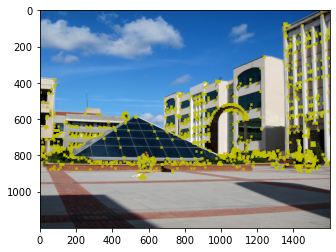

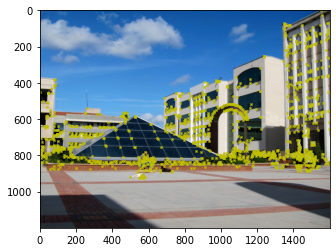

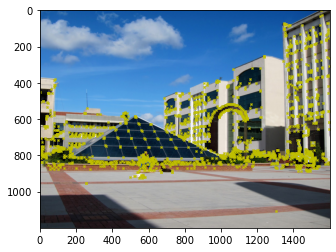

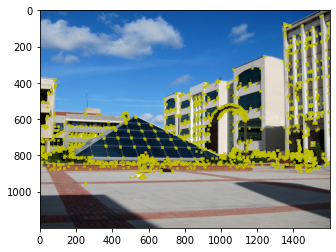

error: OpenCV(3.4.8) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


In [21]:
    run_harris_detector()
    preprocess(variances=[5, 50, 100, 150, 200, 250])   
    measure_repeatability()